# Librerias Necesarias

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pymongo
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Flatten
from keras.layers import TimeDistributed
from keras.models import Model, load_model
from keras.utils import plot_model
from Layers import ConcatenationLayer, LayerExpandOutput, OutputMultiplication, Model_CPMP, Reduction

# Funciones para entrenamiento y predicciones

In [2]:
def expand_dims_cpmp(data: np.ndarray, labels: np.ndarray, stacks: int, height: int):
    """
    The purpuse of this function is to expand the dimensions
    of a smaller state so that it can be predicted by a model 
    for a larger state.

    Input:
        data (ndarray): List of arrays containing all the states.
        labels (ndarray): List of possible source or target stacks.
        stacks (int): Number of stacks allowed by the model.
        height (int): Maximum height of the stacks allowed by the 
                      model.

    Return:
        tuple: Two arrays resized.
    """
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for _ in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [3]:
def cosine_Similarity(y_predict, y_test):
    """
    The puspuse of this function is to verify if the values
    predicted by a multiclass classification deep learning
    mechanism are correct or not.

    Input:

        y_predict (list): Values predicted by the machine 
                          learning.
        y_test (list): Actual values for each case.
    
    Return:
        float: Proportion of correctly predicted values over 
        the total number of cases.
    """
    size = len(y_predict)
    suma = 0

    for i in range(size):
        result = np.dot(y_predict[i], y_test[i]) / (np.linalg.norm(y_predict[i]) * np.linalg.norm(y_test[i]))
        suma += result
    
    return suma / size

# Funciones para cargar data

## Local

In [4]:
def load_data(name: str) -> tuple:
    """
    The purpuse of this function is to load data from 
    a CSV file.

    Input:
        name (string): The name of file containing the
                       data.

    Return:
        tuple: Two arrays containing the states and labels
               of the problem.
    """
    data = []
    labels = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels.append(label_1)

            archivo.readline()

    return np.stack(data), np.stack(labels)

## MongoDB

In [5]:
def connect_to_server(uri: str) -> None:
    """
    The purpose of this function is to establish 
    a connection between the MongoDB server and the program.

    Input:
        uri (string): The URL of the MongoDB server.
    """
    try: 
        client = pymongo.MongoClient(uri, serverSelectionTimeoutMS= 1000)
        client.server_info()
        print('Conection Success')

        return client
    
    except pymongo.errors.ServerSelectionTimeoutError as identifier:
        print('tiempo excedido' + identifier)

    except pymongo.errors.ConnectionFailure as conection_Error:
        print('Error al conectarse a mongodb' + conection_Error)

In [6]:
def load_data_mongo(collection):
    """
    The purpose of this function is to load data from MongoDB.

    Input:
        collection: The MongoDB client's database from which 
                    to load the data.
    """
    data = []
    labels = []

    for states in collection.find():
        data.append(states['State'])
        labels.append(states['Labels'])
    
    return np.stack(data), np.stack(labels)

# CPMP Model

In [7]:
def create_model(num_layer_attention_add: int = 1,
            heads: int = 5, S: int = 5, H: int = 5,
            optimizer: str | None = 'Adam'
            ) -> Model:
    """
    The purpose of this function is to generate a model
    to solve the CPMP (Container Pre-Marshalling Problem)
    using attention layers, a Flatten layer, a Dropout,
    and Dense layers.

    Input:
        heads (int): Number of heads to be used in the
                     attention layer.
        S (int): Maximum number of stacks the model will
                 accept.
        H (int): Maximum height of the stacks the model
                 will accept.
        optimizer (string | None): Optimizer used by the model
                                   during training.
    
    Return:
        Model: The model capable of solving the CPMP problem.
    """
    input = Input(shape=(S, H + 1), dtype= tf.float32)

    model_so = Model_CPMP(num_layer_attention_add, heads, S, H)(input)
    conc = ConcatenationLayer()(input)
    expand = LayerExpandOutput()(model_so)
    model_sd = Model_CPMP(num_layer_attention_add, heads, S= S, H= H + 1)
    distributed = TimeDistributed(model_sd)(conc)
    flatten = Flatten()(distributed)
    dot = OutputMultiplication()(flatten, expand)
    output = Reduction()(dot, S)

    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics= ['mae', 'mse'])

    return model

In [8]:
def load_model(name: str) -> tuple:
    """
    The purpose of this function is to load a neural network model 
    designed to solve the CPMP (Container Pre-Marshalling Problem) 
    using custom layers such as 'Model_CPMP', 'OutputMultiplication', 
    'LayerExpandOutput', 'ConcatenationLayer', and 'Reduction'.

    Input: 
        name (string): The filename that stores the structure of the
                       model along with its weights.

    Return:
        tuple: The model and the input size. 
    """
    custom_objects = {'Model_CPMP': Model_CPMP, 
                        'OutputMultiplication': OutputMultiplication,
                        'LayerExpandOutput': LayerExpandOutput,
                        'ConcatenationLayer': ConcatenationLayer,
                        'Reduction': Reduction}

    model = load_model(name, custom_objects= custom_objects)
    input_shape = model.layers[0].input_shape[0]

    return model, input_shape

In [9]:
def plot_cpmp_model(model: Model = None, name: str = 'model', show_shapes: bool = True) -> None:
    """
    The purpose of this function is to create an image representation of the generated model.

    Input:
        model (Model): Neural network model created using Keras.
        name (string): Name for the model image file.
        show_shapes (bool): Flag to indicate whether to display 
                            the input size for each layer.
    """
    if model is None:
        print('Model have not been initialized.')
        return
    
    input_shape = model.layers[0].input_shape[0]
    name_img = name + str(input_shape[1]) + 'x' + str(input_shape[2] - 1) + '.png'

    plot_model(model, show_shapes=show_shapes, to_file= name_img)

    imagen = plt.imread(name_img)
    plt.figure(figsize=(20, 25))
    plt.imshow(imagen)
    plt.axis('off')
    plt.show()

# Cargar Data

In [10]:
MONGO_URI_MODEL_V2 = 'mongodb+srv://<Username>:<Password>@cluster0.p9y0etq.mongodb.net/'
MONGO_URI_LOCAL = "mongodb://localhost:27017/"

## Local

In [ ]:
data_5x5, labels_5x5 = load_data('Data_CPMP/Data_Model_v2/data_5x5_Multiple')

In [ ]:
data_7x7, labels_7x7 = load_data('data/data_7x7_Multiple')

## MongoDB

### Modelo v2

In [ ]:
client_v2 = connect_to_server(MONGO_URI_MODEL_V2)

base_de_datos = client_v2.data_Model_v2
data_5x5, labels_5x5 = load_data_mongo(base_de_datos.data_5x5)

client_v2.close()

In [19]:
client_v2 = connect_to_server(MONGO_URI_MODEL_V2)

base_de_datos = client_v2.data_Model_v2
data_7x7, labels_7x7 = load_data_mongo(base_de_datos.data_7x7)

client_v2.close()

Conection Success


### Local

In [14]:

client_local = connect_to_server(MONGO_URI_LOCAL)

base_de_datos = client_local['data_model_v2-1']
data_5x5, labels_5x5 = load_data_mongo(base_de_datos.data_5x5)

client_local.close()

Conection Success


## Cargar Modelos

In [18]:
model_5x5_multi = load_model('models/model_cpmp_5x5_test.h5')[0]

In [ ]:
model_7x7_multi = load_model('models/model_cpmp_7x7.h5')[0]

# Modelo con Varias Salidas

## Modelo 5x5

In [23]:
model_5x5_multi = create_model(num_layer_attention_add= 2, heads= 5, S= 5, H= 5, optimizer= 'Adam')

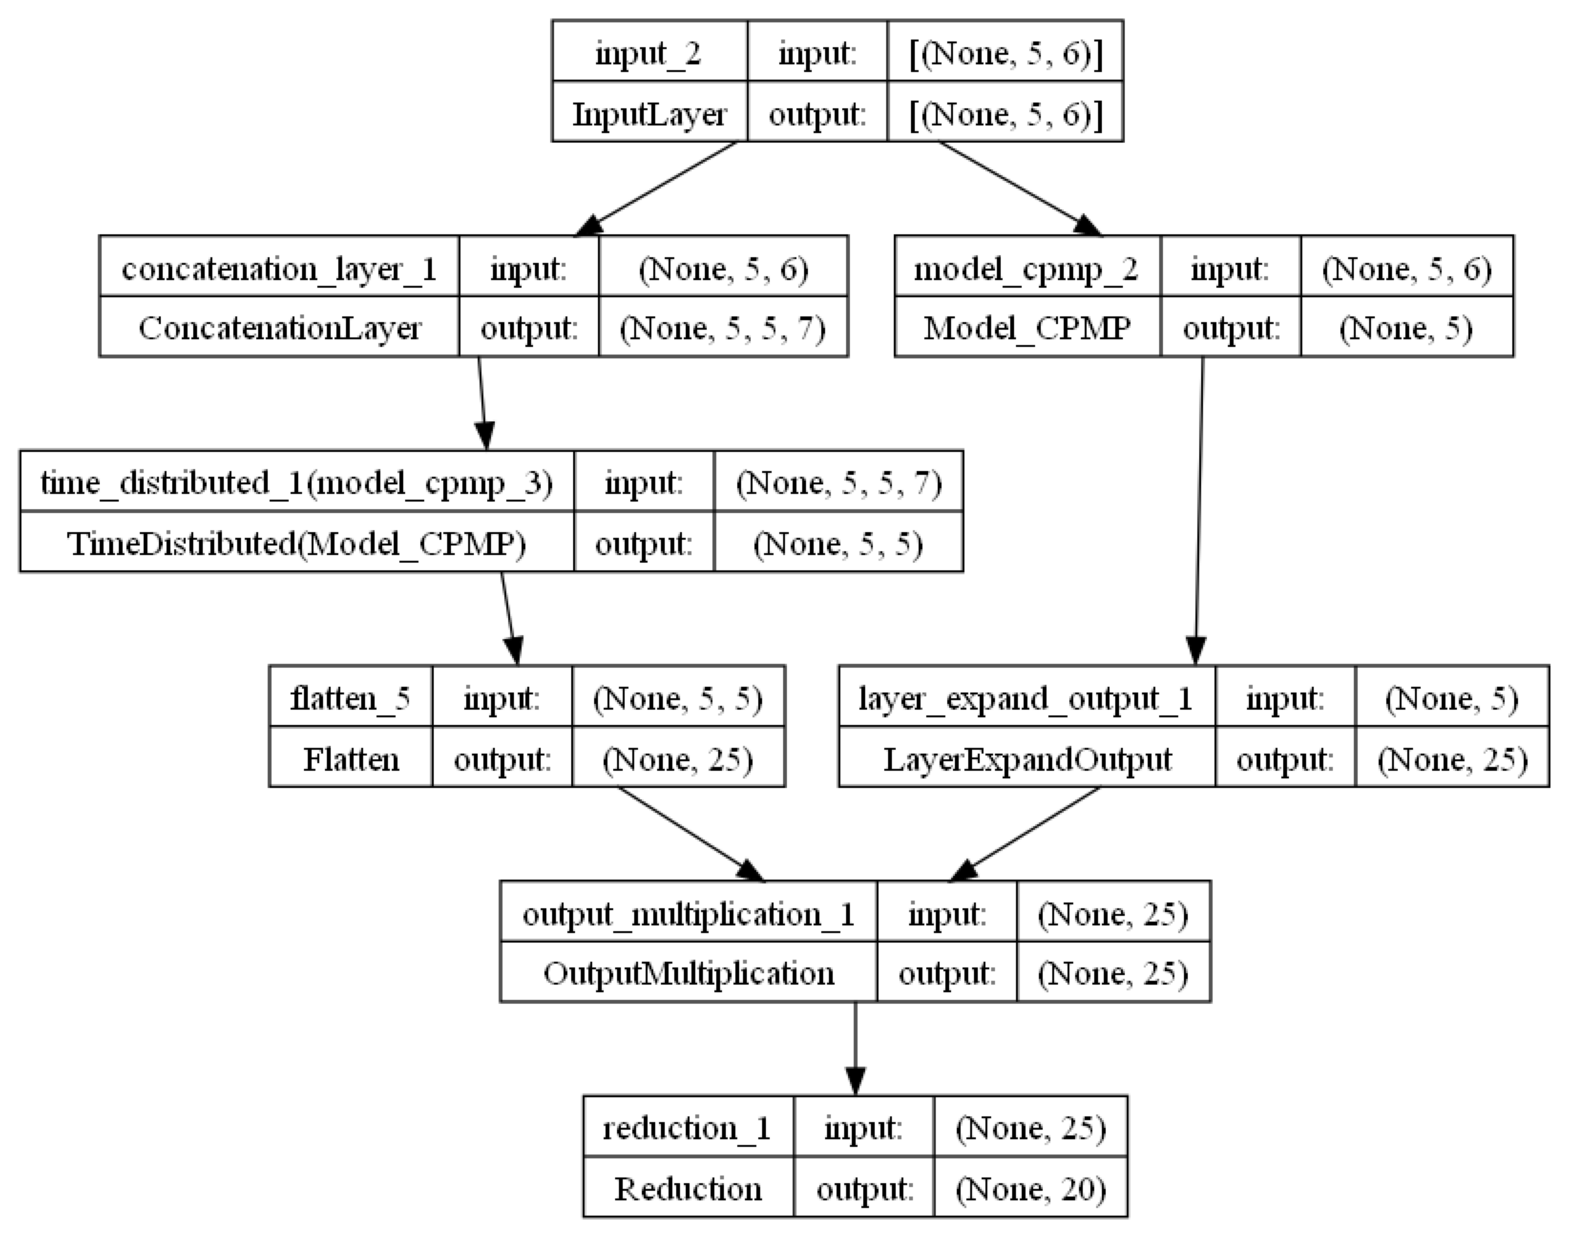

In [24]:
plot_cpmp_model(model_5x5_multi, name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [15]:
X_train_5x5, X_test_5x5, y_train_5x5, y_test_5x5 = train_test_split(data_5x5, labels_5x5, 
                                                                    test_size= 0.2, random_state= 42)

In [26]:
records = model_5x5_multi.fit(X_train_5x5, y_train_5x5, epochs= 50, verbose= True)

Epoch 1/50
6250/6250 [==============================] - 31s 4ms/step - loss: 0.1373 - mae: 0.0872 - mse: 0.0428
Epoch 2/50
6250/6250 [==============================] - 26s 4ms/step - loss: 0.0964 - mae: 0.0624 - mse: 0.0310
Epoch 3/50
6250/6250 [==============================] - 25s 4ms/step - loss: 0.0854 - mae: 0.0554 - mse: 0.0273
Epoch 4/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0772 - mae: 0.0495 - mse: 0.0245
Epoch 5/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0725 - mae: 0.0460 - mse: 0.0228
Epoch 6/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0693 - mae: 0.0438 - mse: 0.0217
Epoch 7/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0668 - mae: 0.0420 - mse: 0.0209
Epoch 8/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0649 - mae: 0.0407 - mse: 0.0202
Epoch 9/50
6250/6250 [==============================] - 24s 4ms/step - loss: 0.0634 - mae: 0.0398 - mse:

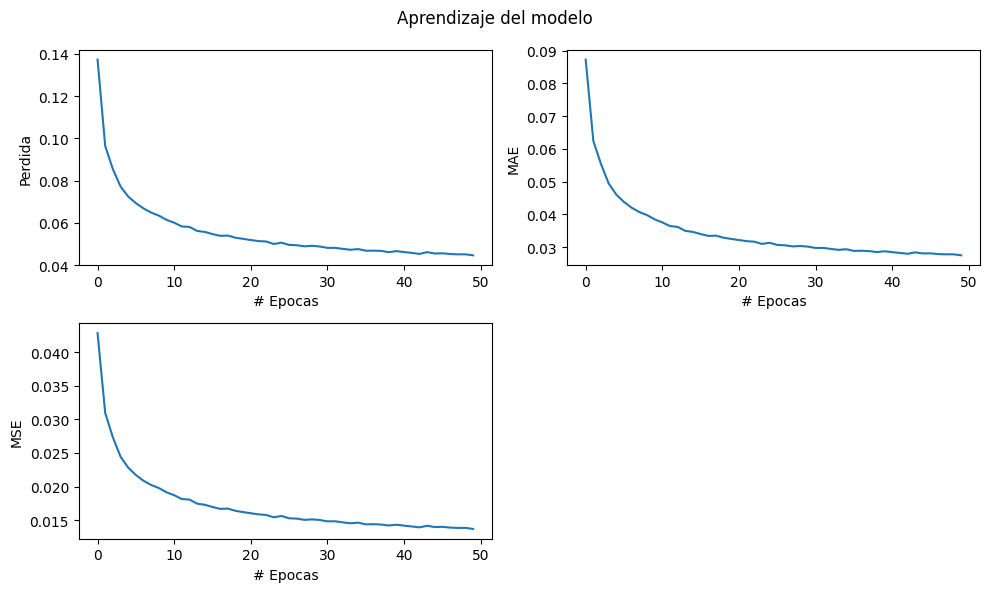

In [27]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(records.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(records.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(records.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

### Testing

In [20]:
predict = model_5x5_multi.predict(X_test_5x5)

1563/1563 [==============================] - 5s 3ms/step


In [21]:
results_1 = cosine_Similarity(predict, y_test_5x5)
results_2 = mean_absolute_error(y_test_5x5, predict)
results_3 = mean_squared_error(y_test_5x5, predict)

print(f'Precisión del modelo: {round(results_1 * 100, 3)}%')
print(f'Error Absoluto Medio: {round(results_2 * 100, 3)}%')
print(f'Error cuadratico medio: {round(results_3 * 100, 3)}%')

Precisión del modelo: 94.748%
Error Absoluto Medio: 2.58%
Error cuadratico medio: 1.239%


In [22]:
model_5x5_multi.save('models/model_cpmp_5x5_test.h5')

c:\Users\matia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model 7x7

In [40]:

model_7x7_multi = create_model(num_layer_attention_add= 2, heads= 5, S= 7, H= 7, optimizer= 'Adam')

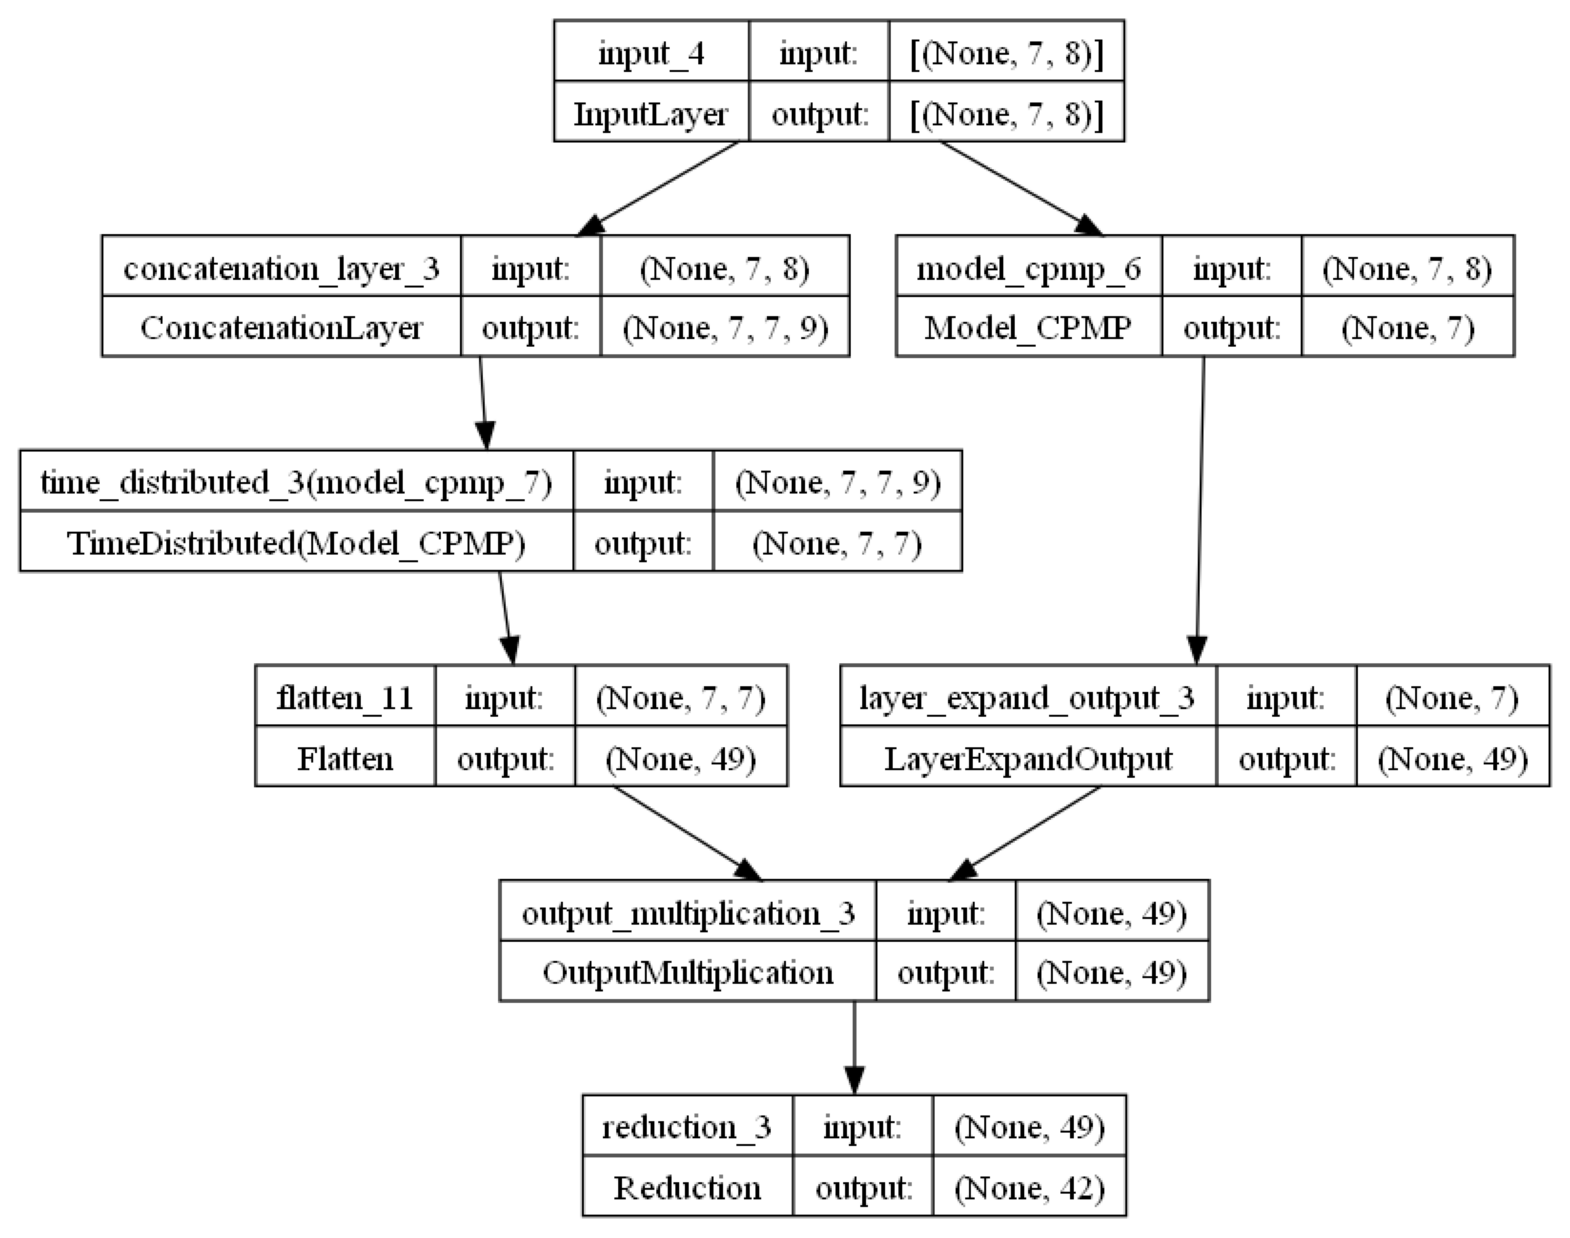

In [41]:
plot_cpmp_model(model_7x7_multi, name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [42]:
X_train_7x7, X_test_7x7, y_train_7x7, y_test_7x7 = train_test_split(data_7x7, labels_7x7, 
                                                                    test_size= 0.2, random_state= 42)

In [43]:
records = model_7x7_multi.fit(X_train_7x7, y_train_7x7, epochs= 50, verbose= True)

Epoch 1/50
2500/2500 [==============================] - 17s 5ms/step - loss: 0.2844 - mae: 0.1608 - mse: 0.0800
Epoch 2/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2554 - mae: 0.1479 - mse: 0.0741
Epoch 3/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2501 - mae: 0.1454 - mse: 0.0730
Epoch 4/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2469 - mae: 0.1439 - mse: 0.0722
Epoch 5/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2447 - mae: 0.1428 - mse: 0.0717
Epoch 6/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2432 - mae: 0.1421 - mse: 0.0713
Epoch 7/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2418 - mae: 0.1414 - mse: 0.0709
Epoch 8/50
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2408 - mae: 0.1409 - mse: 0.0707
Epoch 9/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.2398 - mae: 0.1404 - mse:

### Testing

In [44]:
predict = model_7x7_multi.predict(X_test_7x7)

625/625 [==============================] - 2s 2ms/step


In [45]:
results_1 = cosine_Similarity(predict, y_test_7x7)
results_2 = mean_absolute_error(y_test_7x7, predict)
results_3 = mean_squared_error(y_test_7x7, predict)

print(f'Precisión del modelo: {round(results_1 * 100, 3)}%')
print(f'Error Absoluto Medio: {round(results_2 * 100, 3)}%')
print(f'Error cuadratico medio: {round(results_3 * 100, 3)}%')

Precisión del modelo: 55.5%
Error Absoluto Medio: 12.811%
Error cuadratico medio: 6.691%


In [47]:
model_7x7_multi.save('models/model_cpmp_7x7_v2.h5')